# Description
This notebook aims to download data from lending club and do a initial analysis

# Setup

In [1]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
import re
import numpy as np
from IPython.display import Image

import findspark
import pyspark
from pyspark.sql import SparkSession
import pyspark
from pyspark.sql import DataFrame
import pyspark.sql.functions as sql
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, QuantileDiscretizer

In [2]:
findspark.init()
sc = pyspark.SparkContext(appName="Test")
spark = SparkSession.builder.master("local[*]") \
                    .appName('test') \
                    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/02 22:57:46 WARN Utils: Your hostname, pop-os-note, resolves to a loopback address: 127.0.0.1; using 192.168.0.4 instead (on interface wlp2s0)
25/06/02 22:57:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/02 22:57:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
pd.set_option('display.max_rows', 1000)

In [4]:
input_path = "../data/"
output_path = "../outputs/"

# Data

## raw data input
We'll read the csv file and save as parquet, being a more efficient data type

In [90]:
raw_df = spark.read\
.format("csv")\
.option("header", "True")\
.option("quote", '''"''')\
.option("escape", '''"''')\
.option("inferSchema", "True")\
.load("/home/neon/.cache/kagglehub/datasets/wordsforthewise/lending-club/versions/3/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv")

In [93]:
raw_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: double 

In [91]:
raw_df.limit(5).show()

+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+--------------------+----+------------------+------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+---

In [92]:
raw_df\
.groupBy("loan_status")\
.agg(count("id").alias("count"))\
.show()

+--------------------+-------+
|         loan_status|  count|
+--------------------+-------+
|          Fully Paid|1076751|
|             Default|     40|
|     In Grace Period|   8436|
|         Charged Off| 268559|
|  Late (31-120 days)|  21467|
|             Current| 878317|
|   Late (16-30 days)|   4349|
|                NULL|     33|
|Does not meet the...|   1988|
|Does not meet the...|    761|
+--------------------+-------+



In [94]:
raw_df\
.write\
.mode("overwrite")\
.format("parquet")\
.save(f"{input_path}accepted_2007_to_2018Q4_2.parquet")

## Read parquet

In [5]:
data = spark.read.parquet(f"{input_path}accepted_2007_to_2018Q4_2.parquet")

In [ ]:
# data = pd.read_parquet(f"{input_path}accepted_2007_to_2018Q4_2.parquet")

# Analysis

## Default Rate vs DIfferent features

In [ ]:
loan_status_display = data_selected\
.groupBy("loan_status")\
.agg(count(col("id")).alias("count"))\
.orderBy("loan_status")\
.toPandas()

loan_status_display

,loan_status,count
0,None,33
1,Charged Off,268559
2,Current,878317
3,Default,40
4,Does not meet the credit policy. Status:Charge...,761
5,Does not meet the credit policy. Status:Fully ...,1988
6,Fully Paid,1076751
7,In Grace Period,8436
8,Late (16-30 days),4349
9,Late (31-120 days),21467


In [ ]:
def withTarget(df: DataFrame):
    result = df\
    .withColumn("default_flag", 
                when(col("loan_status").isin(["Default", 
                                              "Charged Off", 
                                              "Does not meet the credit policy. Status:Charged Off"]),
                                              1)
                .when(col("loan_status").isin(["Fully Paid",
                                               "Does not meet the credit policy. Status:Fully Paid"]),
                                              0)
                .when(col("loan_status").isin(["Current",
                                               "In Grace Period",
                                               "Late (16-30 days)",
                                               "Late (31-120 days)"]),
                                             -1)
                .otherwise(-1))
    return result

def filterValidTargetValues(df: DataFrame):
    result = df\
    .where(col("default_flag").isin([1,0]))
    return result

def withDefaultRateGrouped(df: DataFrame, group_col: str):
    result = df
    if data.schema[group_col].dataType.simpleString() in ["double", "int"]:
        quantDisc = QuantileDiscretizer(inputCol=group_col, 
                                        outputCol=f'{group_col}_bands', 
                                        numBuckets=10, 
                                        handleInvalid="keep")
        
        w1 = Window.partitionBy(f'{group_col}_bands').rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
        
        result = quantDisc\
                    .fit(result)\
                    .transform(result)\
                    .withColumn(group_col, 
                                concat(col(f'{group_col}_bands'),
                                       lit(". "),
                                       min(col(group_col)).over(w1),
                                       lit("-"),
                                       max(col(group_col)).over(w1)))
    result = result\
    .groupBy(col(group_col).cast("string").alias("value"))\
    .agg((sum(col("default_flag")) / count(col("default_flag"))).alias("default_rate"),
         count(col("id")).alias("count"))\
    .withColumn("variable", lit(group_col))
    return result

def withDefaultRateGroupedMultipleColumns(df: DataFrame, group_cols: list):
    counter = 0
    for col_i in group_cols:
        if counter == 0:
            result = df.transform(withDefaultRateGrouped, col_i)
            counter = 1
        else:
            result = result\
            .unionByName(
                df.transform(withDefaultRateGrouped, col_i)
            )
    return result


data_chart = data\
.transform(withTarget)\
.transform(filterValidTargetValues)\
.transform(withDefaultRateGroupedMultipleColumns, 
           ["grade",
            "sub_grade", 
            "fico_range_low",
            "int_rate",
            "loan_amnt",
            "emp_length",
            "home_ownership",
            'annual_inc',
            'installment'])\
.toPandas()

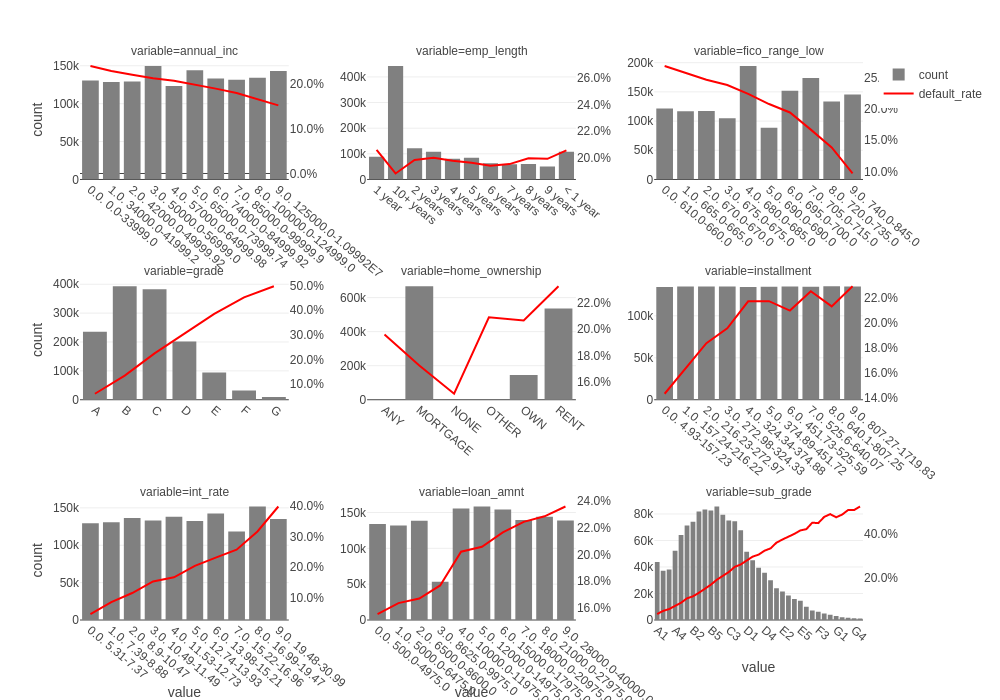

In [ ]:
data_chart = data_chart.sort_values(["variable", "value"])
fig1 = px.line(data_chart,
              x='value',
              y='default_rate',
              facet_col="variable",
              facet_col_wrap=3,
              facet_col_spacing=0.1,
              template='none',
              color_discrete_sequence=['red'],
              category_orders={'variable':data_chart['variable'].drop_duplicates().sort_values()},
              width=700)
fig1.update_traces(name="default_rate", legendgroup="default_rate")
fig1.update_traces(selector={'xaxis':'x'}, showlegend=True)
fig1.update_xaxes(matches=None, showticklabels=True)
fig1.update_yaxes(matches=None, showticklabels=True)

fig2 = px.bar(data_chart,
              x='value',
              y='count',
              facet_col="variable",
              facet_col_wrap=3,
              facet_col_spacing=0.1,
              facet_row_spacing=0.18,
              template='none',
              color_discrete_sequence=['grey'],
              category_orders={'variable':data_chart['variable'].drop_duplicates().sort_values()},
              height=700,
              width=1000)
fig2.update_traces(name="count", legendgroup="count")
fig2.update_traces(selector={'xaxis':'x'}, showlegend=True)

for i, data_i in enumerate(fig1['data']):
    n = len(fig2['data'])+i+1
    y = f'y{n}'
    data_i['yaxis'] = y
    fig2.add_traces(data_i)
    fig2['layout'][f"yaxis{n}"] = {
        'anchor': fig2['data'][i]['xaxis'],
        'overlaying' : fig2['data'][i]['yaxis'],
        'side':'right',
        'tickformat':'0.1%',
        'showgrid':False
    }

fig2.update_xaxes(matches=None, showticklabels=True, tickangle=40)
fig2.update_yaxes(matches=None, showticklabels=True)
Image(fig2.to_image("png"))

## Null analysis

In [ ]:
perc_nulls = data\
.select(
    [(count(when(col(c).isNull(), c)) / count(lit(1))).alias(c) for c in data.columns]
)\
.toPandas()

25/06/02 20:47:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
data_chart = perc_nulls.melt().sort_values("value", ascending=False)
fig = px.bar(
    data_chart,
    y='value',
    x='variable',
    template='none',
    title="Percentage of Null",
    width=700
)
fig.add_hline(y=0.05, annotation={'text':"5%"}, line={'dash':'dash', 'color':'green'})
fig.add_hline(y=0.4 , annotation={'text':"40%"}, line={'dash':'dash', 'color':'red'})
fig

In [ ]:
excluded_cols = perc_nulls.melt()
excluded_cols = excluded_cols[excluded_cols['value']>0.05]['variable'].to_list()
excluded_cols

['member_id',
 'emp_title',
 'emp_length',
 'desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'mo_sin_old_il_acct',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_tl_120dpd_2m',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'defe

In [ ]:
data_nulls_excluded = data\
.select([col for col in data.columns if col not in excluded_cols])

string_select = []
for col in data_nulls_excluded.columns:
    string_select.append(f"CAST({col} AS STRING) AS {col}")

data_nulls_excluded\
.selectExpr(string_select)\
.melt(ids=[], values=[col for col in data_nulls_excluded.columns], variableColumnName="variable", valueColumnName="value")\
.drop_duplicates()\
.groupBy("variable")\
.agg(count(col("value")).alias("n_values"))\
.orderBy("n_values")\
.show()

+--------------------+--------+
|            variable|n_values|
+--------------------+--------+
|         policy_code|       1|
|    application_type|       2|
| initial_list_status|       2|
|          pymnt_plan|       2|
|                term|       2|
| disbursement_method|       2|
|       hardship_flag|       2|
|debt_settlement_flag|       2|
| verification_status|       3|
|        num_tl_30dpd|       5|
|      home_ownership|       6|
|               grade|       7|
|         loan_status|       9|
|      acc_now_delinq|       9|
|chargeoff_within_...|      11|
|pub_rec_bankruptcies|      12|
|             purpose|      14|
|collections_12_mt...|      16|
|      inq_last_6mths|      28|
|  num_tl_op_past_12m|      33|
+--------------------+--------+
only showing top 20 rows


In [ ]:
data_selected = data\
.select([col for col in data.columns if col not in excluded_cols])\
.drop("policy_code")

In [ ]:
class TreeClassifierBinner:
    def __init__(self,
                 data: pd.DataFrame,
                 col_to_bin: str,
                 target_col: str,
                 min_samples_split: float = 0.3,
                 max_leaf_nodes: int = 10):
        self.col_to_bin = col_to_bin
        self.target_col = target_col
        self.max_leaf_nodes = max_leaf_nodes
        self.min_samples_split = min_samples_split
        self.clf = DecisionTreeClassifier(max_leaf_nodes=self.max_leaf_nodes, random_state=42)
        self.data = data
        self.x = data[[self.col_to_bin]]
        self.y = data[self.target_col]
        self.clf.fit(self.x, self.y)
        self.univariate_thresholds = self.uniVariableDecisionTreeThresholds()
    
    def plot(self):
        tree.plot_tree(self.clf)
    
    def uniVariableDecisionTreeThresholds(self):
        self.text_tree = tree.export_text(self.clf, feature_names=[self.col_to_bin])
        result = str(self.text_tree)
        result = result.replace(f"{self.col_to_bin}", "")
        result = re.sub("class: [0-9]", "", result)
        result = re.sub("[0-9., ]", "", result)
        result = re.sub(" +", ", ", result.strip()).split(", ")
        result = list(set([float(x) for x in result])) + [float("-inf"), float("+inf")]
        result.sort()
        return result
    
    def withBands(self, df):
        result = df.copy()
        result[f'{self.col_to_bin}'] = result[f'{self.col_to_bin}'].fillna(result[f'{self.col_to_bin}'].mean())
        result[f'{self.col_to_bin}_bands'] = pd.cut(result[self.col_to_bin], self.univariate_thresholds, labels=False)
        return result

    def defaultRatesByGroups(self, df):
        result = df.groupby(f'{self.col_to_bin}_bands', observed=False)[self.target_col].agg(['count', 'sum'])
        result['total_count'] = result['count'].sum()
        result['m_rate'] = result['sum']/result['count']
        return result.reset_index()

    def calculateWoe(self):
        grouped_data = self.data\
            .pipe(self.withBands)\
            .pipe(self.defaultRatesByGroups)
        grouped_data['non_defaults'] = grouped_data['count'] - grouped_data['sum']
        total_defaults = grouped_data['sum'].sum()
        total_non_defaults = grouped_data['non_defaults'].sum()
        grouped_data['perc_defaults'] = np.clip(grouped_data['sum']/ total_defaults, 0.00001, 0.99999)
        grouped_data['perc_non_defaults'] = np.clip(grouped_data['non_defaults']/ total_non_defaults, 0.00001, 0.99999)
        grouped_data['woe'] = np.log(grouped_data['perc_defaults'] / grouped_data['perc_non_defaults'])
        grouped_data['iv'] = np.sum(-grouped_data['woe'] * (grouped_data['perc_non_defaults'] - grouped_data['perc_defaults']))
        self.woe = grouped_data[[f'{self.col_to_bin}_bands', 'woe', 'iv']]
    
    def addWoeColumn(self, df, na_values=None):
        result = df.pipe(self.withBands)
        result = result.merge(
            self.woe,
            how = 'left',
            on = f'{self.col_to_bin}_bands'
        )
        result = result.drop(columns=['iv'])
        result = result.rename(columns={'woe':f'{self.col_to_bin}_woe'})
        if na_values:
            result[f'{self.col_to_bin}_woe'] = result[f'{self.col_to_bin}_woe'].fillna(na_values)
        return result
    
    
    
class categoryClassifierBinner:
    def __init__(self,
                    data: pd.DataFrame,
                    col_to_bin: str,
                    target_col: str,
                    n_splits:  int = 10,
                    n_samples: int = 10000,
                    n_groups:  int = 50):
        self.n_splits = n_splits
        self.col_to_bin = col_to_bin
        self.target_col = target_col
        self.data = data
        self.n_samples = n_samples
        self.n_groups = n_groups
        self.applyKMeans()
        self.calculateWoe()

    def applyKMeans(self):
        sample = self.data\
        .pipe(self.withDFResampled, self.n_samples, self.n_groups)\
        .pipe(self.defaultRatesByGroups, [self.col_to_bin, 'groups'])

        k_fold_sample = pd.pivot_table(sample, values='m_rate', index=self.col_to_bin, columns='groups').reset_index().set_index(self.col_to_bin)
        kmeans = KMeans(n_clusters=self.n_splits, random_state=42).fit(k_fold_sample)
        k_fold_sample['k_fold_groups'] = kmeans.predict(k_fold_sample)
        k_fold_sample = k_fold_sample.reset_index()
        self.groups_dict = k_fold_sample[[self.col_to_bin, 'k_fold_groups']].set_index(self.col_to_bin).to_dict()
        self.clusters = {}
        for group_i in k_fold_sample['k_fold_groups'].drop_duplicates():
            self.clusters[group_i] = k_fold_sample[k_fold_sample['k_fold_groups']==group_i][self.col_to_bin].to_list()
    
    def withDFResampled(self, df, n_samples, n_groups):
        sample = df.copy()
        sample[self.col_to_bin] = sample[self.col_to_bin].fillna("None")
        sample = sample[[self.col_to_bin, self.target_col]].groupby(self.col_to_bin).sample(n_samples, replace=True, random_state=42).reset_index(drop=True)
        sample['count'] = sample.groupby(self.col_to_bin)[self.target].expanding().count().reset_index()[self.target_col]
        sample['groups'] = pd.cut(sample['count'], n_groups, labels=False)
        return sample

    def withBands(self, df):
        result = df.copy()
        result[f'{self.col_to_bin}'] = result[f'{self.col_to_bin}'].fillna('None')
        result[f'{self.col_to_bin}_bands'] = result[self.col_to_bin].map(self.groups_dict['k_fold_groups'])
        return result
    
    def defaultRatesByGroups(self, df, col_list: list):
        result = df.groupby(col_list, observed=False)[self.target_col].agg(['count', 'sum'])
        result['total_count'] = result['count'].sum()
        result['m_rate'] = np.clip(result['sum']/result['count'], 0.00001, None)
        return result.reset_index()
    
    def calculateWoe(self):
        grouped_data = self.data\
            .pipe(self.withBands)\
            .pipe(self.defaultRatesByGroups, [f"{self.col_to_bin}_bands"])
        grouped_data['non_defaults'] = grouped_data['count'] - grouped_data['sum']
        total_defaults = grouped_data['sum'].sum()
        total_non_defaults = grouped_data['non_defaults'].sum()
        grouped_data['perc_defaults'] = np.clip(grouped_data['sum']/ total_defaults, 0.00001, 0.99999)
        grouped_data['perc_non_defaults'] = np.clip(grouped_data['non_defaults']/ total_non_defaults, 0.00001, 0.99999)
        grouped_data['woe'] = np.log(grouped_data['perc_defaults'] / grouped_data['perc_non_defaults'])
        grouped_data['iv'] = np.sum(-grouped_data['woe'] * (grouped_data['perc_non_defaults'] - grouped_data['perc_defaults']))
        self.woe = grouped_data[[f'{self.col_to_bin}_bands', 'woe', 'iv']]

    def addWoeColumn(self, df, na_values=None):
        result = df.pipe(self.withBands)
        result = result.merge(
            self.woe,
            how = 'left',
            on = f'{self.col_to_bin}_bands'
        )
        result = result.drop(columns=['iv'])
        result = result.rename(columns={'woe':f'{self.col_to_bin}_woe'})
        if na_values:
            result[f'{self.col_to_bin}_woe'] = result[f'{self.col_to_bin}_woe'].fillna(na_values)
        return result


class binnerSelector:
    def __init__(self,
                 data: pd.DataFrame,
                 cols_to_bin: list,
                 target_col: str,
                 iv_threshold: float = 0.02):
        self.data = data
        self.cols_to_bin = cols_to_bin
        self.cols_dict = self.data[cols_to_bin].dtypes.to_dict()
        self.target_col = target_col
        self.removed_cols = {}
        self.selected_cols = {}
        self.runForAllColl()
        self.iv_threshold = iv_threshold
        self.removeFeaturesWithLowIV()
    
    def binCol(self, col_i, n_splits):
        if self.cols_dict[col_i] in ['float', 'int']:
            cat_binner = TreeClassifierBinner(self.data, col_i, self.target_col, max_leaf_nodes=n_splits, min_samples_split=0.01)
        else:
            cat_binner = categoryClassifierBinner(self.data, col_i, self.target_col, n_splits=n_splits, n_samples=10000, n_groups=50)
        return cat_binner

    def selectCategBestBin(self, col_i):
        results = {}
        n_split = 5
        max_splits = len(self.data[col_i].drop_duplicates())
        if max_splits < 3:
            n_split = max_splits
            results[max_splits] = self.binCol(col_i, max_splits)
            print(f"No better adjustment found: bins: {n_split}, iv: {results[n_split].woe['iv'][0]}")
            results['best'] = results[n_split]
            return results
        elif n_split >= max_splits:
            n_split = max_splits - 1
        print(f"starting binning for column: {col_i}")
        results[n_split]   = self.binCol(col_i, n_split)
        results[n_split+1] = self.binCol(col_i, n_split+1)
        results[n_split-1] = self.binCol(col_i, n_split-1)
        while results[n_split+1].woe['iv'][0] > results[n_split].woe['iv'][0]:
            if n_split + 2 > max_splits:
                n_split = n_split + 1
                print("reached maximun splits")
                break
            print(f"bins: {n_split}, iv: {results[n_split].woe['iv'][0]}")
            print(f"bins: {n_split+1}, iv: {results[n_split+1].woe['iv'][0]}")
            n_split = n_split + 1
            results[n_split+1] = self.binCol(col_i, n_split+1)
            if n_split + 3 > max_splits:
                n_split = n_split + 1
                print("reached maximun splits")
                break
        while results[n_split-1].woe['iv'][0] > results[n_split].woe['iv'][0]:
            if n_split -1 < 3:
                print("reached minimum splits")
                break
            else:
                print(f"bins: {n_split}, iv: {results[n_split].woe['iv'][0]}")
                print(f"bins: {n_split-1}, iv: {results[n_split-1].woe['iv'][0]}")
                n_split = n_split - 1
                results[n_split-1] = self.binCol(col_i, n_split-1)
        else:
            print(f"No better adjustment found: bins: {n_split}, iv: {results[n_split].woe['iv'][0]}")
            results['best'] = results[n_split]
        return results
    
    def selectMonotonicBestBin(self, col_i):
        results = {}
        n_split = 5
        max_splits = len(self.data[col_i].drop_duplicates())
        print(f"starting binning for column: {col_i}")
        if max_splits == 1:
            self.removed_cols[col_i] = 'unique value'
            return None
        results[n_split]      =  self.binCol(col_i, n_split)
        results[n_split + 1]  =  self.binCol(col_i, n_split + 1)
        results[n_split - 1]  =  self.binCol(col_i, n_split - 1)
        while results[n_split + 1].woe['iv'][0] > results[n_split - 1].woe['iv'][0]:
            print(f'bins: {n_split}, iv: {results[n_split].woe['iv'][0]}')
            print(f'bins: {n_split+1}, iv: {results[n_split+1].woe['iv'][0]}')
            if results[n_split+1].woe['woe'].is_monotonic_decreasing or results[n_split+1].woe['woe'].is_monotonic_increasing:
                n_split = n_split + 1
                results[n_split + 1] = self.binCol(col_i, n_split + 1)
            else:
                print()
        